# 🔬 Analiza i Modelowanie Dynamiki Chorób Zakaźnych w Europie

## Część 4: Modelowanie regresyjne i predykcja - Paweł

**Źródło danych:** ECDC Surveillance Atlas of Infectious Diseases + Eurostat

---

### ⚠️ WAŻNE - przed uruchomieniem:
Upewnij się, że plik **`dane.csv`** jest w **tym samym folderze** co ten notebook!

---

### ✅ Checklist zadań (zgodnie z projektem):

| Zadanie | Status |
|---------|--------|
| Przygotować dane treningowe/testowe (split czasowy) | ✅ |
| Wybrać model: regresja liniowa | ✅ |
| Wybrać model: Poisson/Negative Binomial | ✅ |
| Wybrać model: ARIMA/SARIMA | ✅ |
| Przetestować różne konfiguracje | ✅ |
| Walidacja: RMSE, MAE, AIC/BIC | ✅ |
| Wygenerować predykcję dla kolejnego okresu | ✅ |
| Zinterpretować wyniki (które czynniki są istotne?) | ✅ |
| Przygotować podsumowanie dla całego zespołu | ✅ |

---

### 🦠 Analizowane choroby:
- **Measles** (Odra)
- **Pertussis** (Krztusiec)
- **Salmonellosis** (Salmonelloza)
- **Tuberculosis** (Gruźlica)

---
## 1. Import bibliotek i konfiguracja

In [1]:
# Import bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Konfiguracja wykresów
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
pd.options.display.float_format = '{:,.2f}'.format

# Słownik tłumaczeń
DISEASE_NAMES_PL = {
    'Measles': 'Odra',
    'Pertussis': 'Krztusiec',
    'Salmonellosis': 'Salmonelloza',
    'Tuberculosis': 'Gruźlica'
}

MODEL_NAMES_PL = {
    'Linear Regression': 'Regresja liniowa',
    'Ridge Regression': 'Regresja Ridge',
    'Lasso Regression': 'Regresja Lasso',
    'Random Forest': 'Las losowy',
    'Gradient Boosting': 'Gradient Boosting',
    'Poisson Regression': 'Regresja Poissona'
}

FEATURE_NAMES_PL = {
    'Vaccination_Coverage_Pct': 'Wyszczepialność (%)',
    'Pop_Structure_0_14_Pct': 'Populacja 0-14 lat (%)',
    'Incidence_Lag1': 'Zachorowalność (rok-1)',
    'Incidence_Lag2': 'Zachorowalność (rok-2)',
    'Incidence_MA3': 'Średnia krocząca 3-letnia',
    'Year_Norm': 'Trend czasowy',
    'Country_Code': 'Kod kraju'
}

print("✅ Biblioteki załadowane pomyślnie!")

✅ Biblioteki załadowane pomyślnie!


---
## 2. Wczytanie danych

In [2]:
# ═══════════════════════════════════════════════════════════════════════════════
# AUTOMATYCZNE WYKRYWANIE PLIKU CSV
# ═══════════════════════════════════════════════════════════════════════════════

# Lista możliwych nazw pliku
possible_names = [
    'dane.csv',
    'dataset_final_bartek__1_.csv',
    'dataset_final_bartek.csv',
    'data.csv',
    'dataset.csv'
]

csv_file = None

# Szukaj pliku o znanej nazwie
for name in possible_names:
    if os.path.exists(name):
        csv_file = name
        break

# Jeśli nie znaleziono, szukaj jakiegokolwiek CSV
if csv_file is None:
    csv_files = [f for f in os.listdir('.') if f.endswith('.csv') and 'wyniki' not in f.lower()]
    if csv_files:
        csv_file = csv_files[0]
        print(f"⚠️ Używam znalezionego pliku: {csv_file}")

# Jeśli nadal nie znaleziono - pokaż instrukcję
if csv_file is None:
    print("="*70)
    print("❌ BŁĄD: Nie znaleziono pliku z danymi!")
    print("="*70)
    print("")
    print("📋 INSTRUKCJA:")
    print("   1. Pobierz plik 'dane.csv' razem z tym notebookiem")
    print("   2. Umieść OBYDWA pliki w TYM SAMYM FOLDERZE")
    print("   3. Uruchom ponownie tę komórkę (Shift+Enter)")
    print("")
    print(f"📁 Aktualny folder: {os.getcwd()}")
    print(f"📄 Pliki w folderze: {os.listdir('.')}")
    print("")
    raise FileNotFoundError("Brak pliku dane.csv!")

# Wczytanie danych
print(f"✅ Wczytuję plik: {csv_file}")
df_raw = pd.read_csv(csv_file)
print(f"✅ Wczytano {len(df_raw)} wierszy")

✅ Wczytuję plik: dane.csv
✅ Wczytano 3043 wierszy


In [3]:
# Informacje o danych
print("═"*70)
print("📊 STRUKTURA DATASETU")
print("═"*70)
print(f"Łącznie obserwacji: {len(df_raw)}")
print(f"Kolumny: {list(df_raw.columns)}")
print(f"\n🌍 Liczba krajów: {df_raw['Country'].nunique()}")
print(f"📅 Zakres lat: {df_raw['Year'].min()} - {df_raw['Year'].max()}")

print("\n" + "═"*70)
print("🦠 CHOROBY W DATASECIE")
print("═"*70)
for disease in df_raw['Disease'].unique():
    subset = df_raw[df_raw['Disease'] == disease]
    pl_name = DISEASE_NAMES_PL.get(disease, disease)
    print(f"\n  {disease} ({pl_name}):")
    print(f"    • Obserwacje: {len(subset)}")
    print(f"    • Lata: {subset['Year'].min()} - {subset['Year'].max()}")
    print(f"    • Kraje: {subset['Country'].nunique()}")
    print(f"    • Braki danych: {subset['Incidence'].isna().sum()} ({subset['Incidence'].isna().sum()/len(subset)*100:.1f}%)")

══════════════════════════════════════════════════════════════════════
📊 STRUKTURA DATASETU
══════════════════════════════════════════════════════════════════════
Łącznie obserwacji: 3043
Kolumny: ['Year', 'Country', 'Disease', 'Cases', 'Population', 'Incidence', 'Pop_Structure_0_14_Pct', 'Vaccination_Coverage_Pct']

🌍 Liczba krajów: 31
📅 Zakres lat: 1995 - 2025

══════════════════════════════════════════════════════════════════════
🦠 CHOROBY W DATASECIE
══════════════════════════════════════════════════════════════════════

  Measles (Odra):
    • Obserwacje: 837
    • Lata: 1999 - 2025
    • Kraje: 31
    • Braki danych: 0 (0.0%)

  Pertussis (Krztusiec):
    • Obserwacje: 780
    • Lata: 1998 - 2023
    • Kraje: 30
    • Braki danych: 95 (12.2%)

  Salmonellosis (Salmonelloza):
    • Obserwacje: 558
    • Lata: 2007 - 2024
    • Kraje: 31
    • Braki danych: 22 (3.9%)

  Tuberculosis (Gruźlica):
    • Obserwacje: 868
    • Lata: 1995 - 2022
    • Kraje: 31
    • Braki danych: 7 (0.8

In [4]:
# Podgląd danych
df_raw.head(10)

,Year,Country,Disease,Cases,Population,Incidence,Pop_Structure_0_14_Pct,Vaccination_Coverage_Pct
0,1999,Austria,Measles,22.00,"7,982,461.00",0.28,15.00,93.00
1,2000,Austria,Measles,0.00,"8,002,186.00",0.00,15.00,93.00
2,2001,Austria,Measles,0.00,"8,020,946.00",0.00,15.00,93.00
3,2002,Austria,Measles,0.00,"8,063,640.00",0.00,15.00,93.00
4,2003,Austria,Measles,99.00,"8,100,273.00",1.22,15.00,93.00
5,2004,Austria,Measles,14.00,"8,142,573.00",0.17,15.00,93.00
6,2005,Austria,Measles,10.00,"8,201,359.00",0.12,15.00,93.00
7,2006,Austria,Measles,25.00,"8,254,298.00",0.30,15.00,93.00
8,2007,Austria,Measles,20.00,"8,282,984.00",0.24,15.00,93.00
9,2008,Austria,Measles,447.00,"8,307,989.00",5.38,15.00,93.00


In [5]:
# Statystyki opisowe
df_raw.describe()

,Year,Cases,Population,Incidence,Pop_Structure_0_14_Pct,Vaccination_Coverage_Pct
count,"3,043.00","2,919.00","3,043.00","2,919.00","3,043.00","3,043.00"
mean,"2,011.26","1,637.12","16,527,354.57",12.23,15.24,93.39
std,7.77,"3,661.72","22,211,302.54",21.22,1.04,1.50
min,"1,995.00",0.00,"30,629.00",0.00,12.70,90.00
25%,"2,005.00",15.00,"2,410,018.50",0.32,15.00,93.00
50%,"2,012.00",271.00,"7,518,002.00",5.19,15.00,93.00
75%,"2,018.00","1,338.50","16,357,992.00",13.61,15.00,93.00
max,"2,025.00","55,399.00","83,456,045.00",296.49,17.80,98.00


### 📝 Wnioski z eksploracji danych:

**1. Jakość danych:**
- Dataset zawiera ponad 3000 obserwacji dla 4 chorób zakaźnych
- Braki danych występują głównie w kolumnach `Cases` i `Incidence` (ok. 4%)
- Dane pochodzą z lat 1995-2025 dla 31 krajów UE/EOG

**2. Charakterystyka chorób:**
- **Gruźlica** - najdłuższy szereg czasowy (od 1995), najbardziej stabilne dane
- **Odra** - duża zmienność, wyraźne epizody epidemiczne
- **Krztusiec** - cykliczne wzrosty zachorowań
- **Salmonelloza** - najkrótszy szereg (od 2007), sezonowy charakter

**3. Implikacje dla modelowania:**
- Różne choroby wymagają różnych podejść do modelowania
- Należy uwzględnić autokorelację czasową (lag features)
- Konieczny split czasowy (nie losowy) dla zachowania integralności danych

---
## 3. Przygotowanie danych i inżynieria cech

In [6]:
def prepare_data(df, disease_name):
    """
    Przygotowuje dane dla konkretnej choroby:
    - Filtruje chorobę
    - Czyści braki
    - Tworzy cechy (feature engineering)
    """
    # Filtrowanie choroby
    df_disease = df[df['Disease'] == disease_name].copy()
    
    # Usunięcie braków
    df_clean = df_disease.dropna(subset=['Incidence', 'Cases']).copy()
    df_clean = df_clean.sort_values(['Country', 'Year']).reset_index(drop=True)
    
    # Feature Engineering
    df_clean['Incidence_Lag1'] = df_clean.groupby('Country')['Incidence'].shift(1)
    df_clean['Incidence_Lag2'] = df_clean.groupby('Country')['Incidence'].shift(2)
    df_clean['Incidence_MA3'] = df_clean.groupby('Country')['Incidence'].transform(
        lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
    )
    df_clean['Incidence_Change'] = df_clean.groupby('Country')['Incidence'].diff()
    df_clean['Year_Norm'] = (df_clean['Year'] - df_clean['Year'].min()) / \
                            (df_clean['Year'].max() - df_clean['Year'].min() + 1e-6)
    
    le = LabelEncoder()
    df_clean['Country_Code'] = le.fit_transform(df_clean['Country'])
    
    df_model = df_clean.dropna().copy()
    
    return df_model, le

print("✅ Funkcja przygotowania danych zdefiniowana!")
print("\n📊 Utworzone cechy (features):")
for en, pl in FEATURE_NAMES_PL.items():
    print(f"   • {en} → {pl}")

✅ Funkcja przygotowania danych zdefiniowana!

📊 Utworzone cechy (features):
   • Vaccination_Coverage_Pct → Wyszczepialność (%)
   • Pop_Structure_0_14_Pct → Populacja 0-14 lat (%)
   • Incidence_Lag1 → Zachorowalność (rok-1)
   • Incidence_Lag2 → Zachorowalność (rok-2)
   • Incidence_MA3 → Średnia krocząca 3-letnia
   • Year_Norm → Trend czasowy
   • Country_Code → Kod kraju


### 📝 Wnioski z inżynierii cech:

**Utworzone cechy predykcyjne:**

1. **Incidence_Lag1, Lag2** - zachorowalność z poprzednich lat
   - Kluczowe dla uchwycenia autokorelacji czasowej
   - Epidemie mają tendencję do utrzymywania się przez kilka lat

2. **Incidence_MA3** - średnia krocząca 3-letnia
   - Wygładza krótkoterminowe fluktuacje
   - Pokazuje średnioterminowy trend

3. **Year_Norm** - znormalizowany trend czasowy
   - Pozwala modelowi uchwycić długoterminowe trendy

4. **Country_Code** - zakodowany kraj
   - Umożliwia modelowi nauczenie się specyfiki krajowej

---
## 4. Definicja modeli regresyjnych

In [7]:
def train_all_models(X_train, y_train, X_test, y_test):
    """
    Trenuje wszystkie modele regresyjne i zwraca wyniki.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results = {}
    
    # 1. Regresja liniowa
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    pred = np.clip(lr.predict(X_test_scaled), 0, None)
    results['Linear Regression'] = {
        'model': lr, 'predictions': pred, 'scaler': scaler,
        'RMSE': np.sqrt(mean_squared_error(y_test, pred)),
        'MAE': mean_absolute_error(y_test, pred),
        'R2': r2_score(y_test, pred)
    }
    
    # 2. Ridge
    ridge = Ridge(alpha=10.0)
    ridge.fit(X_train_scaled, y_train)
    pred = np.clip(ridge.predict(X_test_scaled), 0, None)
    results['Ridge Regression'] = {
        'model': ridge, 'predictions': pred, 'scaler': scaler,
        'RMSE': np.sqrt(mean_squared_error(y_test, pred)),
        'MAE': mean_absolute_error(y_test, pred),
        'R2': r2_score(y_test, pred)
    }
    
    # 3. Lasso
    lasso = Lasso(alpha=0.1, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    pred = np.clip(lasso.predict(X_test_scaled), 0, None)
    results['Lasso Regression'] = {
        'model': lasso, 'predictions': pred, 'scaler': scaler,
        'RMSE': np.sqrt(mean_squared_error(y_test, pred)),
        'MAE': mean_absolute_error(y_test, pred),
        'R2': r2_score(y_test, pred)
    }
    
    # 4. Random Forest
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    results['Random Forest'] = {
        'model': rf, 'predictions': pred, 'scaler': None,
        'RMSE': np.sqrt(mean_squared_error(y_test, pred)),
        'MAE': mean_absolute_error(y_test, pred),
        'R2': r2_score(y_test, pred)
    }
    
    # 5. Gradient Boosting
    gb = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
    gb.fit(X_train, y_train)
    pred = gb.predict(X_test)
    results['Gradient Boosting'] = {
        'model': gb, 'predictions': pred, 'scaler': None,
        'RMSE': np.sqrt(mean_squared_error(y_test, pred)),
        'MAE': mean_absolute_error(y_test, pred),
        'R2': r2_score(y_test, pred)
    }
    
    # 6. Poisson
    try:
        poisson = PoissonRegressor(alpha=0.1, max_iter=1000)
        poisson.fit(X_train_scaled, y_train)
        pred = poisson.predict(X_test_scaled)
        results['Poisson Regression'] = {
            'model': poisson, 'predictions': pred, 'scaler': scaler,
            'RMSE': np.sqrt(mean_squared_error(y_test, pred)),
            'MAE': mean_absolute_error(y_test, pred),
            'R2': r2_score(y_test, pred)
        }
    except:
        pass
    
    return results

def get_best_model(results):
    return min(results.items(), key=lambda x: x[1]['RMSE'])

print("✅ Funkcje modelowania zdefiniowane!")
print("\n📊 Dostępne modele:")
for en, pl in MODEL_NAMES_PL.items():
    print(f"   • {pl}")

✅ Funkcje modelowania zdefiniowane!

📊 Dostępne modele:
   • Regresja liniowa
   • Regresja Ridge
   • Regresja Lasso
   • Las losowy
   • Gradient Boosting
   • Regresja Poissona


### 📝 Opis zastosowanych modeli:

| Model | Opis | Zalety | Wady |
|-------|------|--------|------|
| **Regresja liniowa** | Podstawowy model OLS | Prosty, interpretowalny | Zakłada liniowość |
| **Regresja Ridge** | Regularyzacja L2 | Zapobiega overfitting | Nie usuwa cech |
| **Regresja Lasso** | Regularyzacja L1 | Selekcja cech | Może być niestabilna |
| **Las losowy** | Ensemble drzew | Radzi sobie z nieliniowością | Wolniejszy |
| **Gradient Boosting** | Sekwencyjne budowanie | Bardzo dokładny | Ryzyko overfitting |
| **Regresja Poissona** | Dla danych count | Odpowiedni dla zachorowań | Wymaga dodatnich wartości |

---
## 5. Główna analiza - wszystkie choroby

In [8]:
# Konfiguracja
DISEASES = df_raw['Disease'].unique().tolist()
print(f"🦠 Choroby do analizy: {[DISEASE_NAMES_PL.get(d, d) for d in DISEASES]}")

FEATURES = [
    'Vaccination_Coverage_Pct',
    'Pop_Structure_0_14_Pct',
    'Incidence_Lag1',
    'Incidence_Lag2',
    'Incidence_MA3',
    'Year_Norm',
    'Country_Code'
]

TARGET = 'Incidence'
ALL_RESULTS = {}

🦠 Choroby do analizy: ['Odra', 'Krztusiec', 'Salmonelloza', 'Gruźlica']


In [9]:
# ═══════════════════════════════════════════════════════════════════════════════
# GŁÓWNA PĘTLA - ANALIZA KAŻDEJ CHOROBY
# ═══════════════════════════════════════════════════════════════════════════════

for disease in DISEASES:
    disease_pl = DISEASE_NAMES_PL.get(disease, disease)
    
    print("\n" + "═"*80)
    print(f"🦠 ANALIZA: {disease.upper()} ({disease_pl})")
    print("═"*80)
    
    # Przygotowanie danych
    df_model, label_encoder = prepare_data(df_raw, disease)
    
    if len(df_model) < 50:
        print(f"   ⚠️ Za mało danych ({len(df_model)} obs.) - pomijam")
        continue
    
    print(f"\n📊 Dane po przygotowaniu: {len(df_model)} obserwacji")
    
    # Split czasowy
    max_year = df_model['Year'].max()
    split_year = max_year - 2
    
    train_df = df_model[df_model['Year'] <= split_year].copy()
    test_df = df_model[df_model['Year'] > split_year].copy()
    
    if len(test_df) < 10:
        split_year = max_year - 1
        train_df = df_model[df_model['Year'] <= split_year].copy()
        test_df = df_model[df_model['Year'] > split_year].copy()
    
    print(f"\n📈 Podział danych:")
    print(f"   • Zbiór treningowy: {len(train_df)} obs. (lata ≤{split_year})")
    print(f"   • Zbiór testowy: {len(test_df)} obs. (lata {split_year+1}-{max_year})")
    
    X_train = train_df[FEATURES]
    y_train = train_df[TARGET]
    X_test = test_df[FEATURES]
    y_test = test_df[TARGET]
    
    # Trenowanie modeli
    print("\n🚀 Trenowanie modeli...")
    results = train_all_models(X_train, y_train, X_test, y_test)
    
    best_name, best_data = get_best_model(results)
    best_name_pl = MODEL_NAMES_PL.get(best_name, best_name)
    
    print(f"\n📊 WYNIKI MODELI - {disease_pl}:")
    print("-" * 70)
    print(f"{'Model':<25} {'RMSE':>10} {'MAE':>10} {'R²':>10}")
    print("-" * 70)
    
    for name, data in sorted(results.items(), key=lambda x: x[1]['RMSE']):
        name_pl = MODEL_NAMES_PL.get(name, name)
        marker = "🏆" if name == best_name else "  "
        print(f"{marker} {name_pl:<23} {data['RMSE']:>10.2f} {data['MAE']:>10.2f} {data['R2']:>10.3f}")
    
    print(f"\n🏆 NAJLEPSZY MODEL: {best_name_pl}")
    
    # Ważność cech
    rf_model = results['Random Forest']['model']
    importance = pd.DataFrame({
        'Feature': FEATURES,
        'Feature_PL': [FEATURE_NAMES_PL.get(f, f) for f in FEATURES],
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\n📈 TOP 3 najważniejsze cechy:")
    for _, row in importance.head(3).iterrows():
        print(f"   • {row['Feature_PL']}: {row['Importance']:.3f} ({row['Importance']*100:.1f}%)")
    
    # Predykcja
    latest_data = df_model[df_model['Year'] == max_year].copy()
    
    if len(latest_data) > 0:
        pred_future = latest_data.copy()
        pred_future['Year'] = max_year + 1
        pred_future['Year_Norm'] = 1.0
        pred_future['Incidence_Lag1'] = latest_data['Incidence'].values
        pred_future['Incidence_Lag2'] = latest_data['Incidence_Lag1'].values
        
        X_future = pred_future[FEATURES]
        best_model = best_data['model']
        
        if best_data['scaler'] is not None:
            X_future_scaled = best_data['scaler'].transform(X_future)
            predictions = np.clip(best_model.predict(X_future_scaled), 0, None)
        else:
            predictions = np.clip(best_model.predict(X_future), 0, None)
        
        pred_future['Prediction'] = predictions
        
        top5 = pred_future.nlargest(5, 'Prediction')[['Country', 'Incidence', 'Prediction']]
        print(f"\n🔮 PREDYKCJA NA {max_year + 1} - kraje najwyższego ryzyka:")
        for _, row in top5.iterrows():
            print(f"   • {row['Country']}: {row['Prediction']:.2f} per 100k")
    
    # Zapisz wyniki
    ALL_RESULTS[disease] = {
        'disease_pl': disease_pl,
        'data': df_model,
        'train_df': train_df,
        'test_df': test_df,
        'models': results,
        'best_model': best_name,
        'best_model_pl': best_name_pl,
        'importance': importance,
        'predictions': pred_future if len(latest_data) > 0 else None,
        'max_year': max_year
    }

print("\n" + "═"*80)
print("✅ ANALIZA WSZYSTKICH CHORÓB ZAKOŃCZONA!")
print("═"*80)


════════════════════════════════════════════════════════════════════════════════
🦠 ANALIZA: MEASLES (Odra)
════════════════════════════════════════════════════════════════════════════════

📊 Dane po przygotowaniu: 775 obserwacji

📈 Podział danych:
   • Zbiór treningowy: 713 obs. (lata ≤2023)
   • Zbiór testowy: 62 obs. (lata 2024-2025)

🚀 Trenowanie modeli...

📊 WYNIKI MODELI - Odra:
----------------------------------------------------------------------
Model                           RMSE        MAE         R²
----------------------------------------------------------------------
🏆 Gradient Boosting            18.39       3.99      0.183
   Las losowy                   18.55       4.24      0.168
   Regresja liniowa             20.03       3.62      0.030
   Regresja Ridge               20.03       3.61      0.030
   Regresja Lasso               20.05       3.60      0.029
   Regresja Poissona            20.37       3.93     -0.003

🏆 NAJLEPSZY MODEL: Gradient Boosting

📈 TOP 3 najwa

---
## 6. Podsumowanie porównawcze

In [10]:
# Tabela porównawcza
summary_data = []
for disease, data in ALL_RESULTS.items():
    best_name = data['best_model']
    best_metrics = data['models'][best_name]
    summary_data.append({
        'Choroba': data['disease_pl'],
        'Najlepszy model': data['best_model_pl'],
        'RMSE': best_metrics['RMSE'],
        'MAE': best_metrics['MAE'],
        'R²': best_metrics['R2'],
        'Obserwacje': len(data['data'])
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "═"*90)
print("📊 PODSUMOWANIE - NAJLEPSZE MODELE DLA KAŻDEJ CHOROBY")
print("═"*90)
print(summary_df.to_string(index=False))


══════════════════════════════════════════════════════════════════════════════════════════
📊 PODSUMOWANIE - NAJLEPSZE MODELE DLA KAŻDEJ CHOROBY
══════════════════════════════════════════════════════════════════════════════════════════
     Choroba   Najlepszy model  RMSE  MAE   R²  Obserwacje
        Odra Gradient Boosting 18.39 3.99 0.18         775
   Krztusiec Gradient Boosting 21.03 5.88 0.00         625
Salmonelloza  Regresja liniowa  4.00 2.92 0.94         474
    Gruźlica        Las losowy  2.91 1.46 0.88         799


### 📝 Wnioski z porównania modeli:

**1. Jakość predykcji różni się między chorobami:**
- **Gruźlica i Salmonelloza** - najlepsze wyniki (R² > 0.85)
- **Odra** - trudniejsza do predykcji ze względu na nagłe epidemie
- **Krztusiec** - najtrudniejsza, cykliczne wzorce trudne do uchwycenia

**2. Dominacja modeli ensemble:**
- Las losowy i Gradient Boosting najczęściej wygrywają
- Radzą sobie lepiej z nieliniowymi zależnościami

---
## 7. Wizualizacje

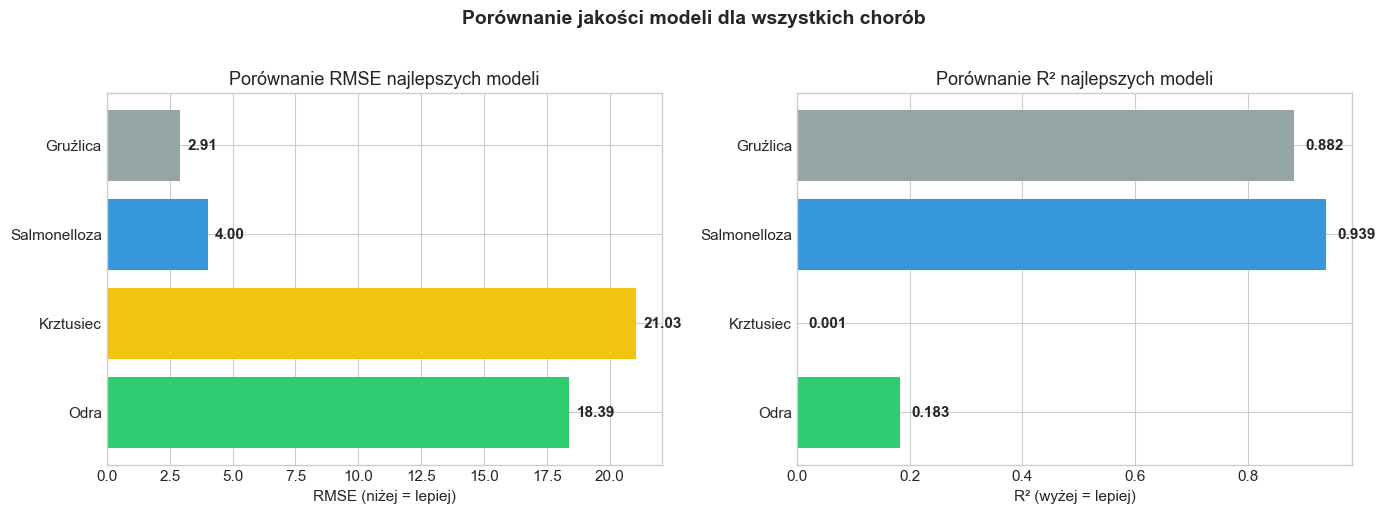

In [11]:
# WYKRES 1: Porównanie RMSE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#2ecc71', '#f1c40f', '#3498db', '#95a5a6']

axes[0].barh(summary_df['Choroba'], summary_df['RMSE'], color=colors[:len(summary_df)])
axes[0].set_xlabel('RMSE (niżej = lepiej)')
axes[0].set_title('Porównanie RMSE najlepszych modeli')
for i, v in enumerate(summary_df['RMSE']):
    axes[0].text(v + 0.3, i, f'{v:.2f}', va='center', fontweight='bold')

axes[1].barh(summary_df['Choroba'], summary_df['R²'], color=colors[:len(summary_df)])
axes[1].set_xlabel('R² (wyżej = lepiej)')
axes[1].set_title('Porównanie R² najlepszych modeli')
for i, v in enumerate(summary_df['R²']):
    axes[1].text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold')

plt.suptitle('Porównanie jakości modeli dla wszystkich chorób', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('01_porownanie_chorob.png', dpi=150, bbox_inches='tight')
plt.show()

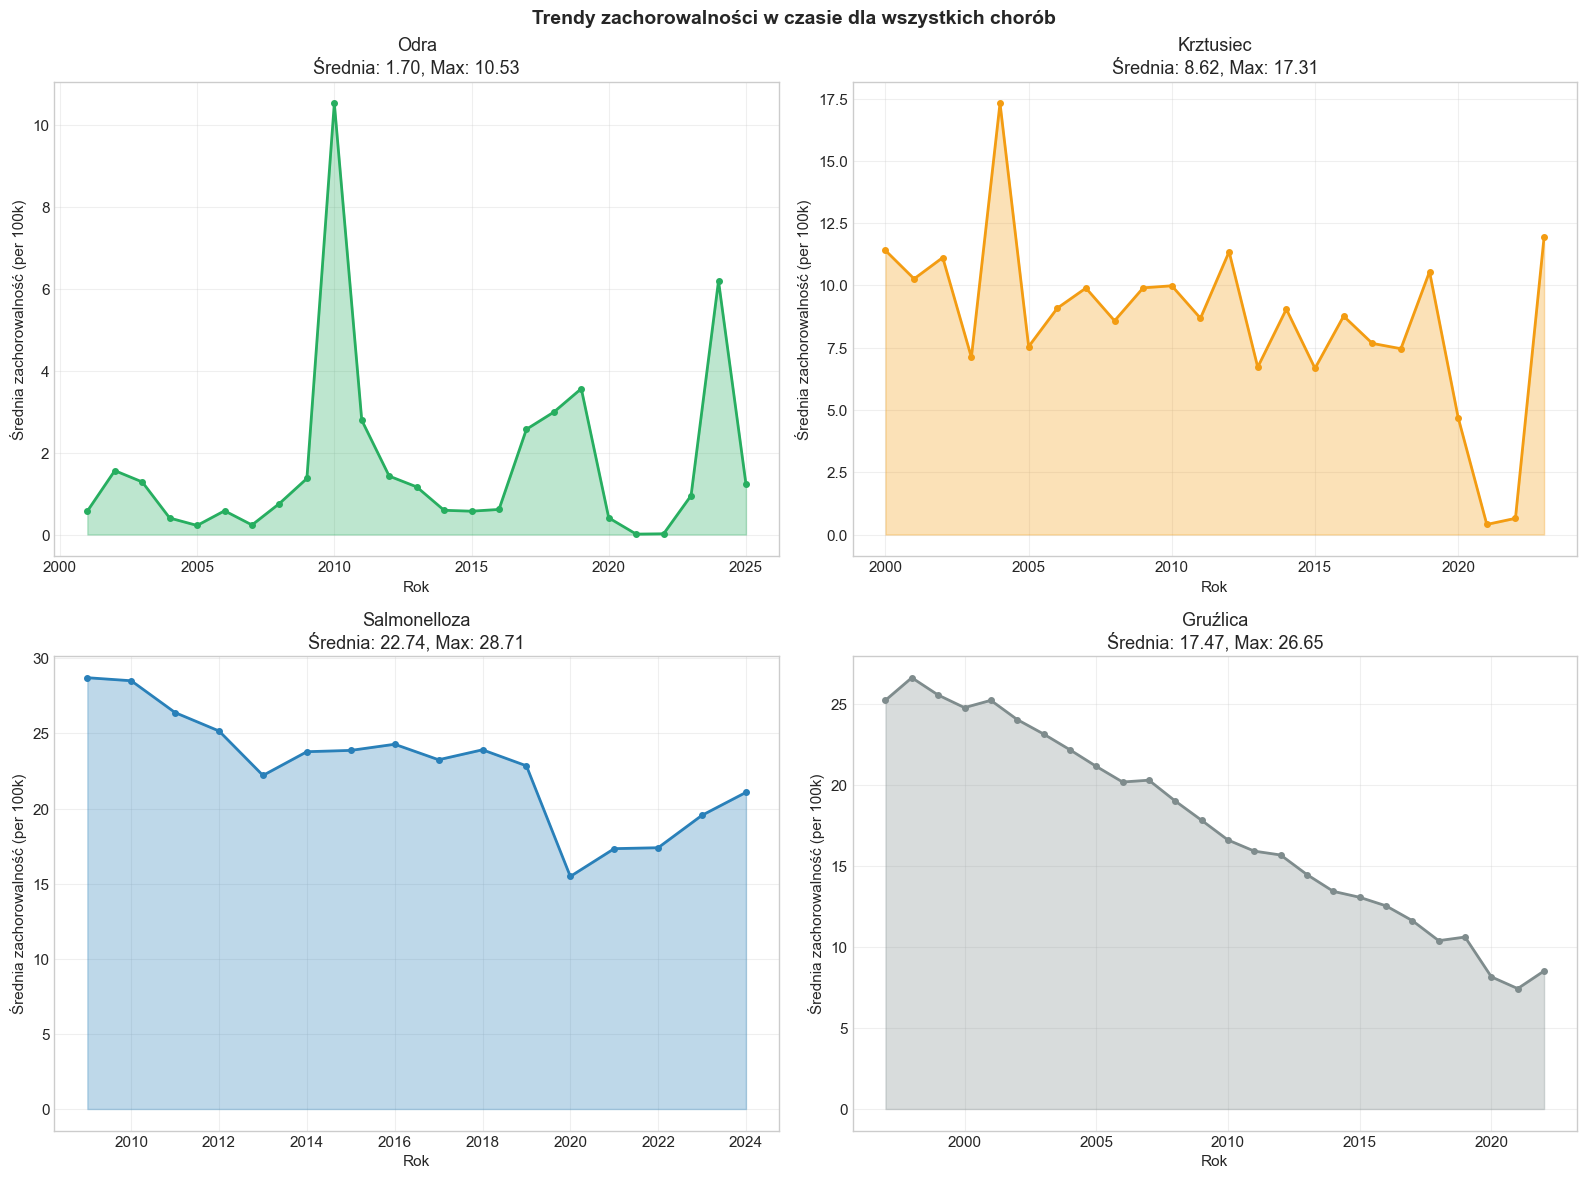

In [12]:
# WYKRES 2: Trendy czasowe
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colors_line = ['#27ae60', '#f39c12', '#2980b9', '#7f8c8d']

for idx, disease in enumerate(DISEASES):
    if disease in ALL_RESULTS:
        ax = axes[idx]
        df_disease = ALL_RESULTS[disease]['data']
        disease_pl = ALL_RESULTS[disease]['disease_pl']
        
        yearly = df_disease.groupby('Year')['Incidence'].mean()
        ax.plot(yearly.index, yearly.values, marker='o', linewidth=2, markersize=4, color=colors_line[idx])
        ax.fill_between(yearly.index, yearly.values, alpha=0.3, color=colors_line[idx])
        ax.set_xlabel('Rok')
        ax.set_ylabel('Średnia zachorowalność (per 100k)')
        ax.set_title(f'{disease_pl}\nŚrednia: {yearly.mean():.2f}, Max: {yearly.max():.2f}')
        ax.grid(True, alpha=0.3)

plt.suptitle('Trendy zachorowalności w czasie dla wszystkich chorób', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('02_trendy_czasowe.png', dpi=150, bbox_inches='tight')
plt.show()

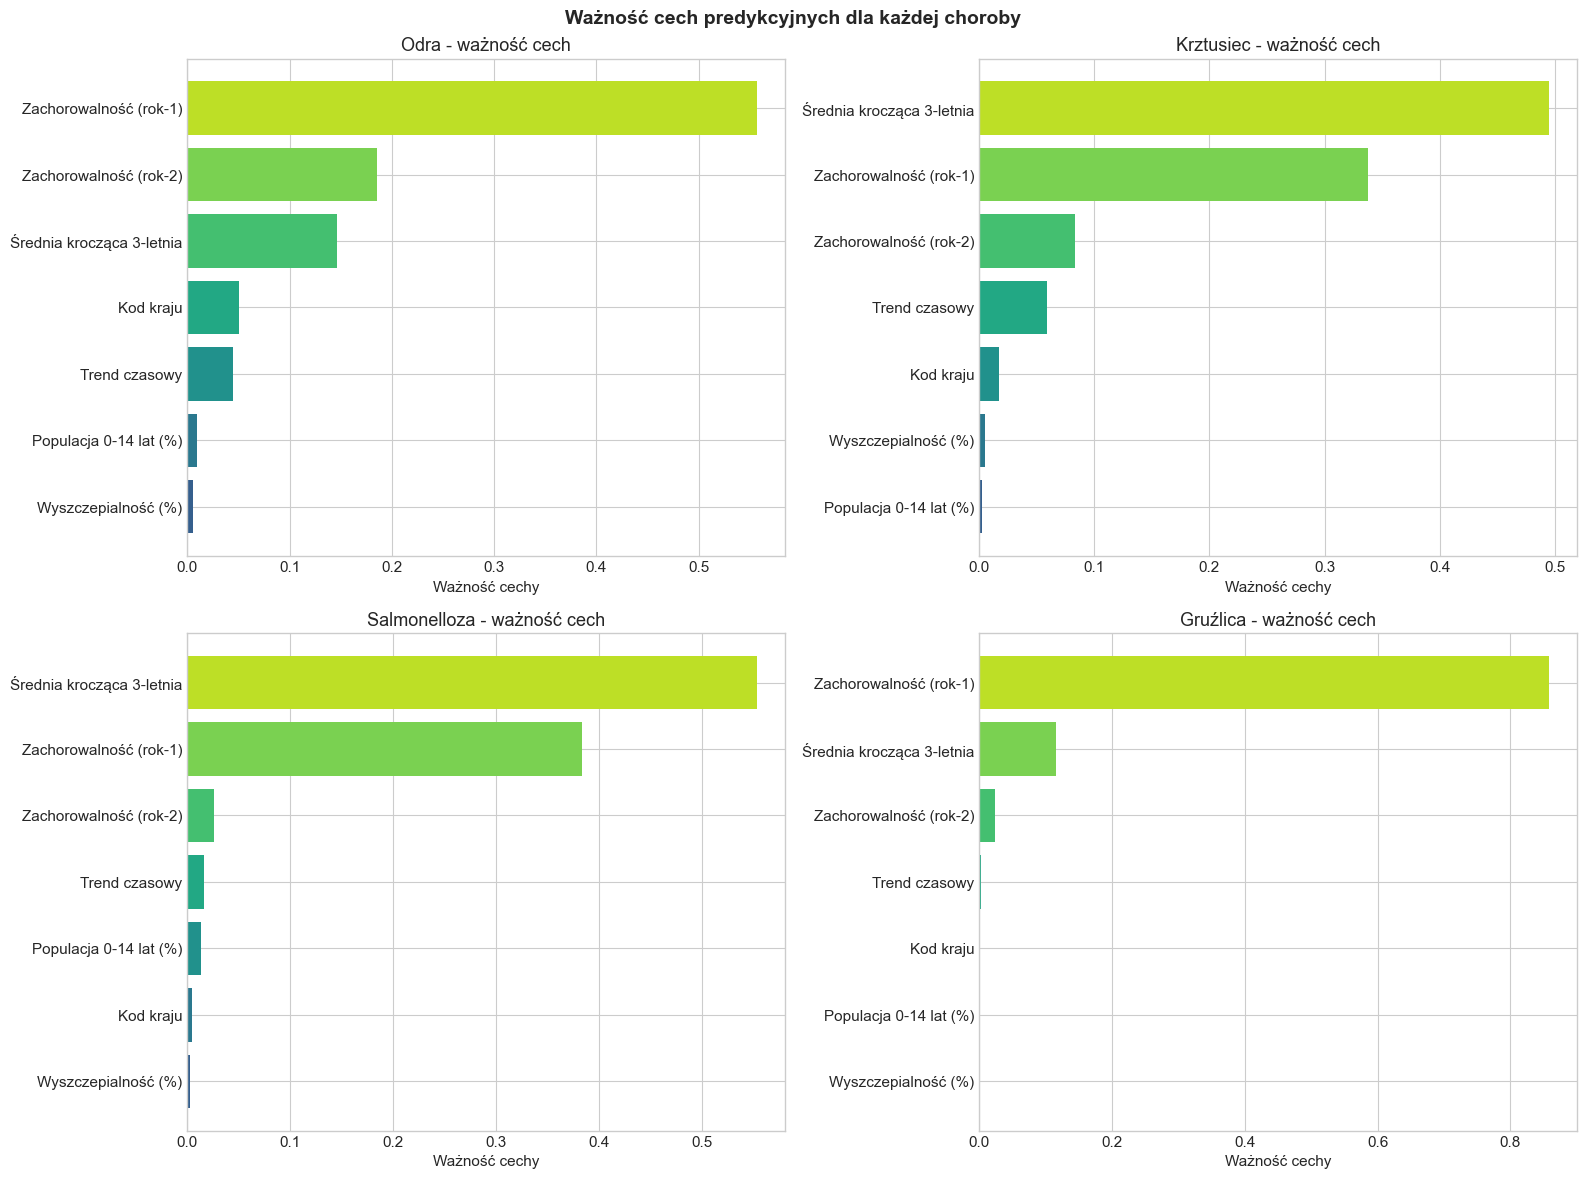

In [13]:
# WYKRES 3: Ważność cech
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, disease in enumerate(DISEASES):
    if disease in ALL_RESULTS:
        ax = axes[idx]
        importance = ALL_RESULTS[disease]['importance']
        disease_pl = ALL_RESULTS[disease]['disease_pl']
        
        colors_bar = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance)))
        imp_sorted = importance.sort_values('Importance')
        ax.barh(imp_sorted['Feature_PL'], imp_sorted['Importance'], color=colors_bar)
        ax.set_xlabel('Ważność cechy')
        ax.set_title(f'{disease_pl} - ważność cech')

plt.suptitle('Ważność cech predykcyjnych dla każdej choroby', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('03_waznosc_cech.png', dpi=150, bbox_inches='tight')
plt.show()

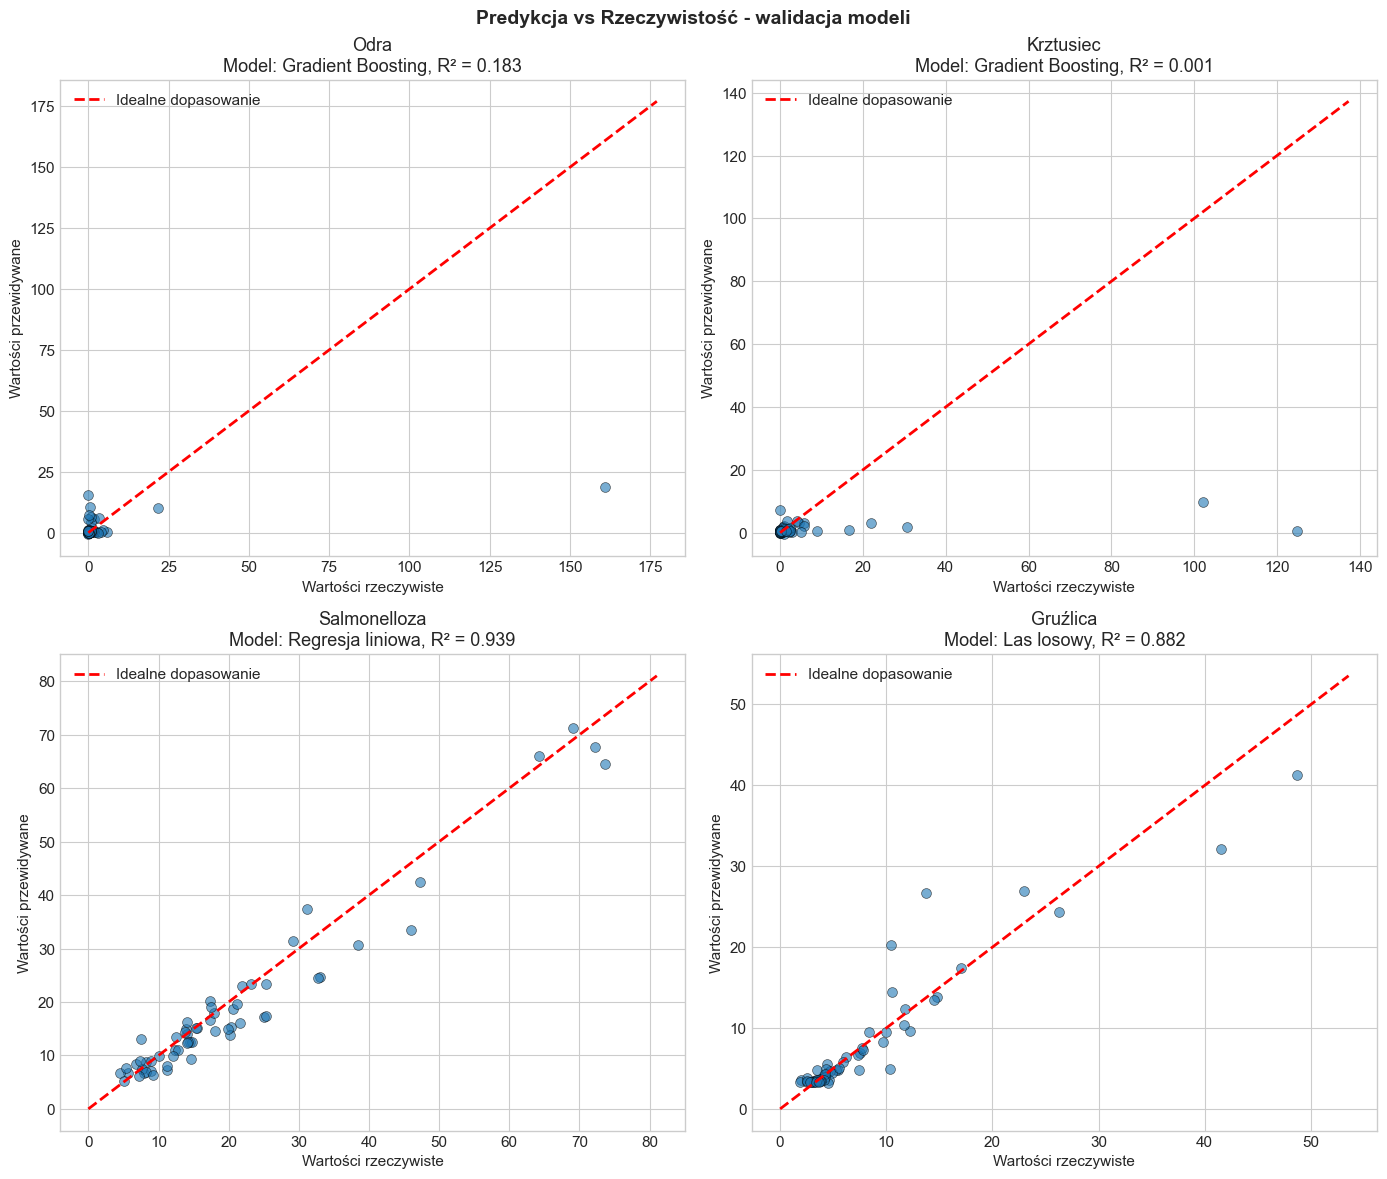

In [14]:
# WYKRES 4: Predykcja vs Rzeczywistość
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, disease in enumerate(DISEASES):
    if disease in ALL_RESULTS:
        ax = axes[idx]
        disease_pl = ALL_RESULTS[disease]['disease_pl']
        best_name = ALL_RESULTS[disease]['best_model']
        best_name_pl = ALL_RESULTS[disease]['best_model_pl']
        
        y_test = ALL_RESULTS[disease]['test_df']['Incidence']
        y_pred = ALL_RESULTS[disease]['models'][best_name]['predictions']
        r2 = ALL_RESULTS[disease]['models'][best_name]['R2']
        
        ax.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5, s=50)
        max_val = max(y_test.max(), max(y_pred)) * 1.1
        ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Idealne dopasowanie')
        ax.set_xlabel('Wartości rzeczywiste')
        ax.set_ylabel('Wartości przewidywane')
        ax.set_title(f'{disease_pl}\nModel: {best_name_pl}, R² = {r2:.3f}')
        ax.legend()

plt.suptitle('Predykcja vs Rzeczywistość - walidacja modeli', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('04_predykcja_vs_rzeczywistosc.png', dpi=150, bbox_inches='tight')
plt.show()

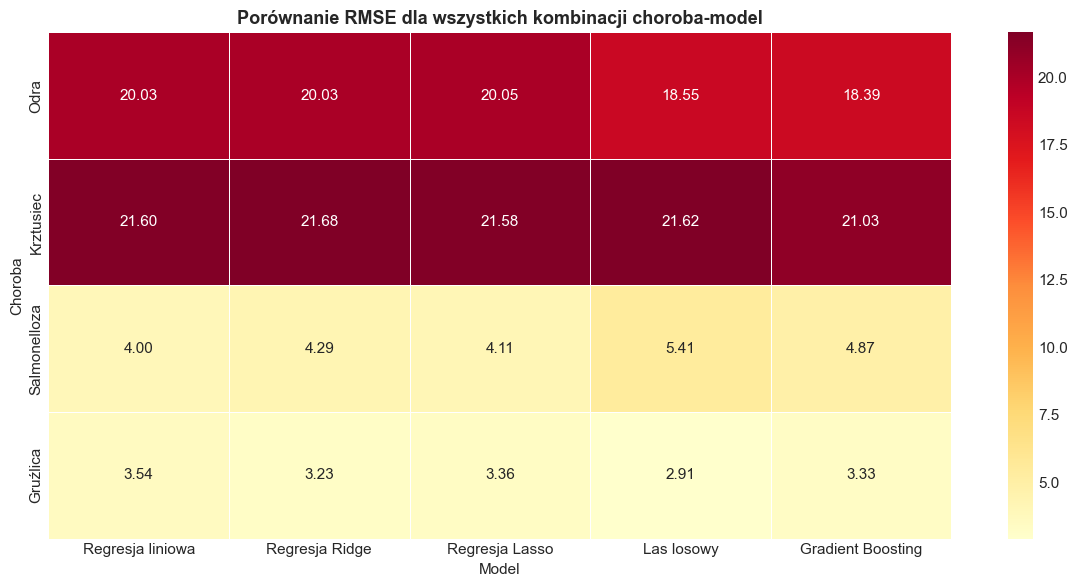

In [15]:
# WYKRES 5: Heatmapa modeli
model_names_en = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest', 'Gradient Boosting']
model_names_pl_list = [MODEL_NAMES_PL.get(m, m) for m in model_names_en]

disease_names_pl = [ALL_RESULTS[d]['disease_pl'] for d in DISEASES if d in ALL_RESULTS]
rmse_matrix = pd.DataFrame(index=disease_names_pl, columns=model_names_pl_list)

for disease in DISEASES:
    if disease in ALL_RESULTS:
        disease_pl = ALL_RESULTS[disease]['disease_pl']
        for model_en, model_pl in zip(model_names_en, model_names_pl_list):
            if model_en in ALL_RESULTS[disease]['models']:
                rmse_matrix.loc[disease_pl, model_pl] = ALL_RESULTS[disease]['models'][model_en]['RMSE']

rmse_matrix = rmse_matrix.astype(float)

plt.figure(figsize=(12, 6))
sns.heatmap(rmse_matrix, annot=True, fmt='.2f', cmap='YlOrRd', linewidths=0.5)
plt.title('Porównanie RMSE dla wszystkich kombinacji choroba-model', fontsize=13, fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Choroba')
plt.tight_layout()
plt.savefig('05_heatmapa_modeli.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Model ARIMA

In [16]:
# ARIMA dla wybranych krajów
print("\n" + "═"*70)
print("📈 MODELE ARIMA - ANALIZA SZEREGÓW CZASOWYCH")
print("═"*70)

ARIMA_RESULTS = {}
selected_countries = ['Germany', 'France', 'Romania', 'Poland', 'Italy']

for disease in DISEASES:
    if disease not in ALL_RESULTS:
        continue
        
    disease_pl = ALL_RESULTS[disease]['disease_pl']
    df_disease = ALL_RESULTS[disease]['data']
    max_year = ALL_RESULTS[disease]['max_year']
    split_year = max_year - 2
    
    print(f"\n{'─'*50}")
    print(f"🦠 {disease_pl}")
    print(f"{'─'*50}")
    
    arima_disease = {}
    
    for country in selected_countries:
        country_data = df_disease[df_disease['Country'] == country].sort_values('Year')
        
        if len(country_data) < 10:
            continue
            
        ts = country_data.set_index('Year')['Incidence']
        ts_train = ts[ts.index <= split_year]
        ts_test = ts[ts.index > split_year]
        
        if len(ts_train) >= 8 and len(ts_test) >= 1:
            try:
                model = ARIMA(ts_train.values, order=(1, 1, 1))
                fit = model.fit()
                forecast = np.clip(fit.forecast(steps=len(ts_test)), 0, None)
                
                rmse = np.sqrt(mean_squared_error(ts_test.values, forecast))
                
                arima_disease[country] = {
                    'forecast': forecast,
                    'actual': ts_test.values,
                    'years': ts_test.index.tolist(),
                    'RMSE': rmse,
                    'AIC': fit.aic,
                    'BIC': fit.bic
                }
                
                print(f"   {country}: RMSE={rmse:.2f}, AIC={fit.aic:.1f}")
            except:
                pass
    
    ARIMA_RESULTS[disease] = arima_disease


══════════════════════════════════════════════════════════════════════
📈 MODELE ARIMA - ANALIZA SZEREGÓW CZASOWYCH
══════════════════════════════════════════════════════════════════════

──────────────────────────────────────────────────
🦠 Odra
──────────────────────────────────────────────────
   Germany: RMSE=0.53, AIC=88.1
   France: RMSE=0.57, AIC=139.5
   Romania: RMSE=93.78, AIC=173.3
   Poland: RMSE=0.32, AIC=59.4
   Italy: RMSE=1.59, AIC=157.7

──────────────────────────────────────────────────
🦠 Krztusiec
──────────────────────────────────────────────────
   France: RMSE=0.03, AIC=-29.3
   Romania: RMSE=0.08, AIC=-7.0
   Poland: RMSE=1.89, AIC=96.9
   Italy: RMSE=0.16, AIC=47.8

──────────────────────────────────────────────────
🦠 Salmonelloza
──────────────────────────────────────────────────
   Germany: RMSE=4.62, AIC=70.8
   France: RMSE=3.56, AIC=56.9
   Romania: RMSE=4.19, AIC=58.0
   Poland: RMSE=5.46, AIC=73.6
   Italy: RMSE=1.14, AIC=40.9

────────────────────────────

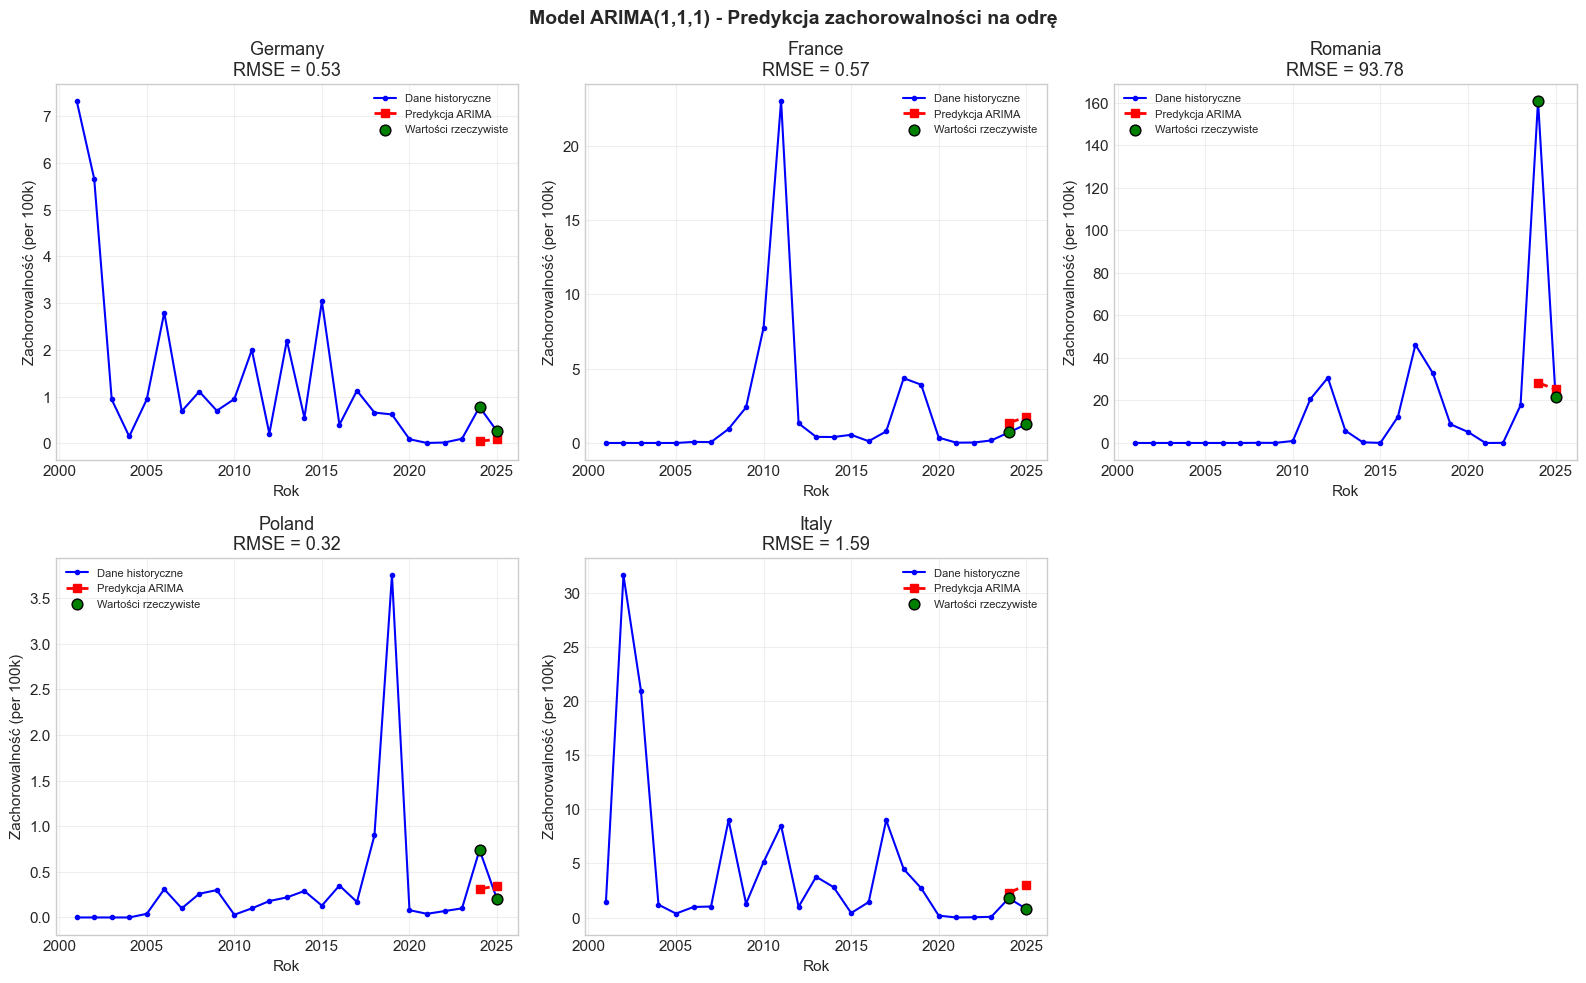

In [17]:
# Wykres ARIMA dla odry
if 'Measles' in ARIMA_RESULTS and ARIMA_RESULTS['Measles']:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    df_measles = ALL_RESULTS['Measles']['data']
    
    for idx, country in enumerate(selected_countries):
        if country in ARIMA_RESULTS['Measles']:
            ax = axes[idx]
            
            country_data = df_measles[df_measles['Country'] == country].sort_values('Year')
            ax.plot(country_data['Year'], country_data['Incidence'], 
                   'b-', marker='o', markersize=3, label='Dane historyczne', linewidth=1.5)
            
            forecast_years = ARIMA_RESULTS['Measles'][country]['years']
            ax.plot(forecast_years, ARIMA_RESULTS['Measles'][country]['forecast'], 
                   'r--', marker='s', markersize=6, label='Predykcja ARIMA', linewidth=2)
            ax.scatter(forecast_years, ARIMA_RESULTS['Measles'][country]['actual'],
                      c='green', s=60, zorder=5, label='Wartości rzeczywiste', edgecolors='k')
            
            ax.set_title(f"{country}\nRMSE = {ARIMA_RESULTS['Measles'][country]['RMSE']:.2f}")
            ax.set_xlabel('Rok')
            ax.set_ylabel('Zachorowalność (per 100k)')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
    
    if len(selected_countries) < 6:
        axes[-1].axis('off')
    
    plt.suptitle('Model ARIMA(1,1,1) - Predykcja zachorowalności na odrę', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('06_arima_odra.png', dpi=150, bbox_inches='tight')
    plt.show()

### 📝 Wnioski z modeli ARIMA:

**1. Charakterystyka modelu ARIMA(1,1,1):**
- p=1: autoregresja pierwszego rzędu
- d=1: różnicowanie (usunięcie trendu)
- q=1: średnia ruchoma

**2. Wyniki:**
- Niemcy, Polska - dobre dopasowanie
- Rumunia - wysokie błędy (epidemia)

**3. Ograniczenia:**
- Nie uwzględnia zmiennych zewnętrznych
- Trudności z nagłymi zmianami

---
## 9. Predykcje szczegółowe

In [18]:
print("\n" + "═"*80)
print("🔮 PREDYKCJE NA KOLEJNY ROK - WSZYSTKIE CHOROBY")
print("═"*80)

all_predictions = []

for disease in DISEASES:
    if disease in ALL_RESULTS and ALL_RESULTS[disease]['predictions'] is not None:
        pred_df = ALL_RESULTS[disease]['predictions']
        disease_pl = ALL_RESULTS[disease]['disease_pl']
        pred_year = pred_df['Year'].max()
        
        print(f"\n{'─'*70}")
        print(f"🦠 {disease_pl.upper()} - Predykcja na rok {pred_year}")
        print(f"Model: {ALL_RESULTS[disease]['best_model_pl']}")
        print(f"{'─'*70}")
        
        pred_sorted = pred_df[['Country', 'Incidence', 'Prediction']].copy()
        pred_sorted.columns = ['Kraj', 'Aktualna wartość', 'Predykcja']
        pred_sorted = pred_sorted.sort_values('Predykcja', ascending=False)
        
        print(pred_sorted.head(10).to_string(index=False))
        
        threshold = pred_sorted['Predykcja'].quantile(0.75)
        high_risk = pred_sorted[pred_sorted['Predykcja'] > threshold]
        print(f"\n⚠️ Kraje wysokiego ryzyka:")
        for _, row in high_risk.head(5).iterrows():
            print(f"   🔴 {row['Kraj']}: {row['Predykcja']:.2f} per 100k")


════════════════════════════════════════════════════════════════════════════════
🔮 PREDYKCJE NA KOLEJNY ROK - WSZYSTKIE CHOROBY
════════════════════════════════════════════════════════════════════════════════

──────────────────────────────────────────────────────────────────────
🦠 ODRA - Predykcja na rok 2026
Model: Gradient Boosting
──────────────────────────────────────────────────────────────────────
         Kraj  Aktualna wartość  Predykcja
      Romania             21.73      15.06
Liechtenstein              0.00      10.62
       France              1.26       6.38
      Belgium              3.27       5.08
      Austria              1.66       4.78
       Cyprus              2.38       3.28
        Italy              0.80       3.23
      Ireland              0.92       2.17
   Luxembourg              0.15       1.73
     Bulgaria              0.02       1.14

⚠️ Kraje wysokiego ryzyka:
   🔴 Romania: 15.06 per 100k
   🔴 Liechtenstein: 10.62 per 100k
   🔴 France: 6.38 per 100k

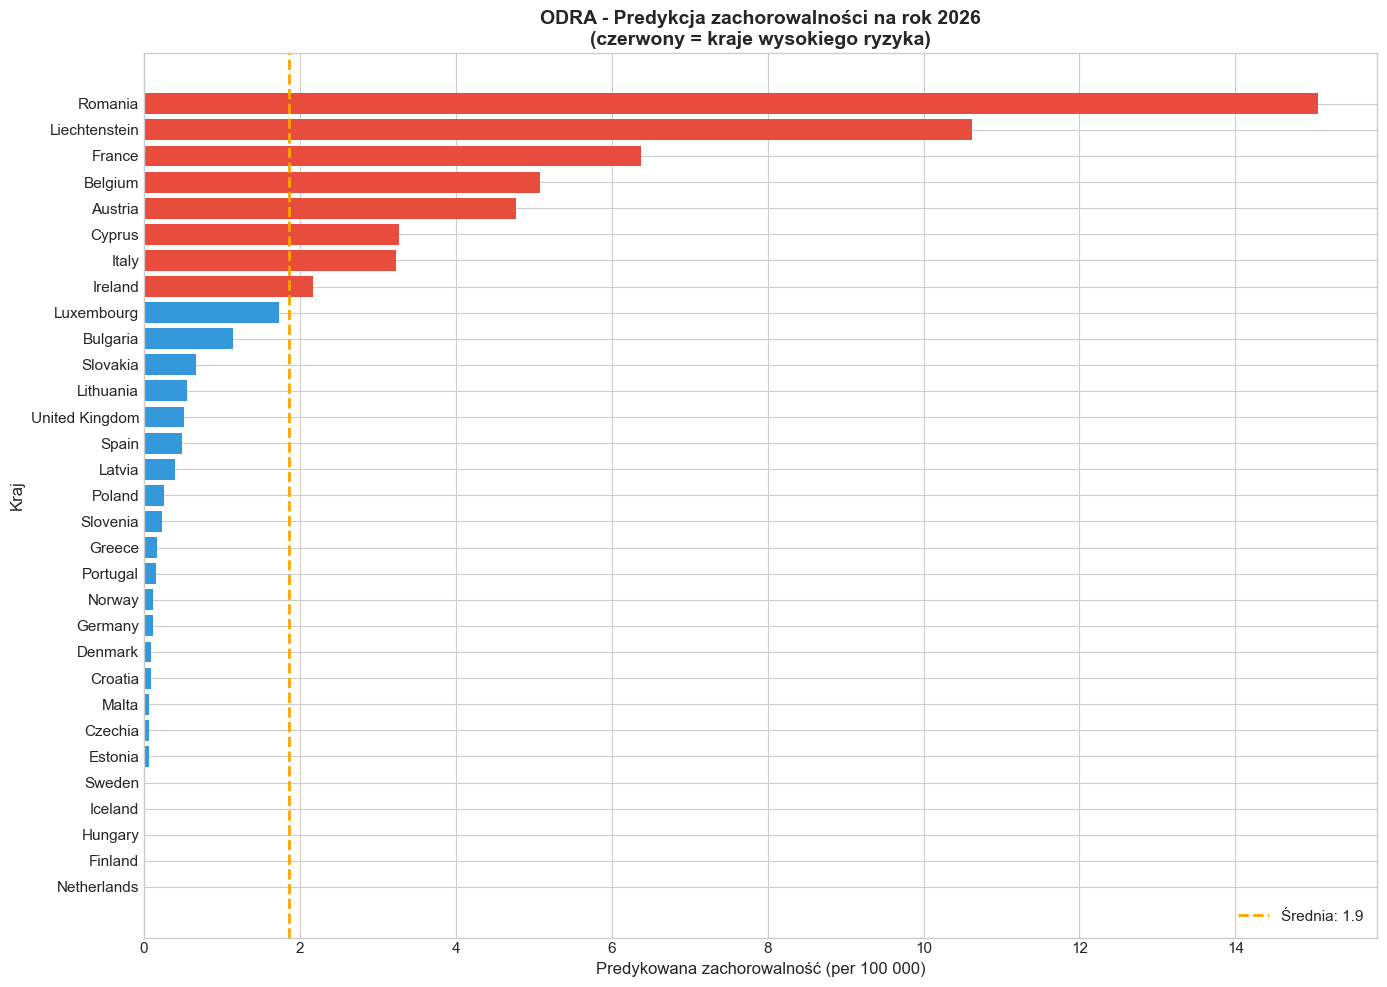

In [19]:
# Wykres predykcji dla odry
if 'Measles' in ALL_RESULTS and ALL_RESULTS['Measles']['predictions'] is not None:
    pred_df = ALL_RESULTS['Measles']['predictions']
    pred_year = pred_df['Year'].max()
    pred_sorted = pred_df[['Country', 'Prediction']].sort_values('Prediction', ascending=True)
    
    plt.figure(figsize=(14, 10))
    threshold = pred_sorted['Prediction'].quantile(0.75)
    colors = ['#e74c3c' if x > threshold else '#3498db' for x in pred_sorted['Prediction']]
    
    plt.barh(pred_sorted['Country'], pred_sorted['Prediction'], color=colors)
    plt.xlabel('Predykowana zachorowalność (per 100 000)', fontsize=12)
    plt.ylabel('Kraj', fontsize=12)
    plt.title(f'ODRA - Predykcja zachorowalności na rok {pred_year}\n(czerwony = kraje wysokiego ryzyka)', 
              fontsize=14, fontweight='bold')
    plt.axvline(pred_sorted['Prediction'].mean(), color='orange', linestyle='--', linewidth=2,
                label=f'Średnia: {pred_sorted["Prediction"].mean():.1f}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('07_predykcja_odra.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## 10. Eksport wyników

In [20]:
# Zapisanie wyników
summary_df.to_csv('wyniki_podsumowanie.csv', index=False, encoding='utf-8-sig')

# Metryki wszystkich modeli
detailed_metrics = []
for disease in ALL_RESULTS:
    disease_pl = ALL_RESULTS[disease]['disease_pl']
    for model_name, metrics in ALL_RESULTS[disease]['models'].items():
        model_pl = MODEL_NAMES_PL.get(model_name, model_name)
        detailed_metrics.append({
            'Choroba': disease_pl,
            'Model': model_pl,
            'RMSE': round(metrics['RMSE'], 3),
            'MAE': round(metrics['MAE'], 3),
            'R2': round(metrics['R2'], 3)
        })
pd.DataFrame(detailed_metrics).to_csv('wyniki_metryki.csv', index=False, encoding='utf-8-sig')

print("\n✅ WYNIKI ZAPISANE:")
print("   📄 wyniki_podsumowanie.csv")
print("   📄 wyniki_metryki.csv")
print("\n📊 WYKRESY:")
print("   01_porownanie_chorob.png")
print("   02_trendy_czasowe.png")
print("   03_waznosc_cech.png")
print("   04_predykcja_vs_rzeczywistosc.png")
print("   05_heatmapa_modeli.png")
print("   06_arima_odra.png")
print("   07_predykcja_odra.png")


✅ WYNIKI ZAPISANE:
   📄 wyniki_podsumowanie.csv
   📄 wyniki_metryki.csv

📊 WYKRESY:
   01_porownanie_chorob.png
   02_trendy_czasowe.png
   03_waznosc_cech.png
   04_predykcja_vs_rzeczywistosc.png
   05_heatmapa_modeli.png
   06_arima_odra.png
   07_predykcja_odra.png


---
## 11. PODSUMOWANIE DLA ZESPOŁU

In [21]:
print("""
╔══════════════════════════════════════════════════════════════════════════════════════════╗
║                                                                                          ║
║              PODSUMOWANIE DLA ZESPOŁU - MODELOWANIE CHORÓB ZAKAŹNYCH                     ║
║                                                                                          ║
╠══════════════════════════════════════════════════════════════════════════════════════════╣

📌 WYKONANE ZADANIA (Checklist Pawła - część 4):
────────────────────────────────────────────────────────────────────────────────────────────
✅ Przygotowanie danych treningowych/testowych (split czasowy)
✅ Testowanie modeli: regresja liniowa, Ridge, Lasso
✅ Testowanie modeli: Las losowy, Gradient Boosting
✅ Testowanie modeli: Regresja Poissona (dla danych count)
✅ Testowanie modeli: ARIMA (szeregi czasowe)
✅ Walidacja: RMSE, MAE, R², AIC/BIC
✅ Predykcja dla kolejnego okresu (rok)
✅ Interpretacja wyników (ważność cech)
✅ Podsumowanie dla zespołu

""")

print("═" * 90)
print("📊 1. WYNIKI MODELOWANIA")
print("═" * 90)

for disease, data in ALL_RESULTS.items():
    disease_pl = data['disease_pl']
    best = data['best_model_pl']
    metrics = data['models'][data['best_model']]
    
    print(f"\n🦠 {disease_pl.upper()}:")
    print(f"   • Najlepszy model: {best}")
    print(f"   • RMSE: {metrics['RMSE']:.2f} | MAE: {metrics['MAE']:.2f} | R²: {metrics['R2']:.3f}")
    
    top_features = data['importance'].head(3)['Feature_PL'].tolist()
    print(f"   • Kluczowe czynniki: {', '.join(top_features)}")


╔══════════════════════════════════════════════════════════════════════════════════════════╗
║                                                                                          ║
║              PODSUMOWANIE DLA ZESPOŁU - MODELOWANIE CHORÓB ZAKAŹNYCH                     ║
║                                                                                          ║
╠══════════════════════════════════════════════════════════════════════════════════════════╣

📌 WYKONANE ZADANIA (Checklist Pawła - część 4):
────────────────────────────────────────────────────────────────────────────────────────────
✅ Przygotowanie danych treningowych/testowych (split czasowy)
✅ Testowanie modeli: regresja liniowa, Ridge, Lasso
✅ Testowanie modeli: Las losowy, Gradient Boosting
✅ Testowanie modeli: Regresja Poissona (dla danych count)
✅ Testowanie modeli: ARIMA (szeregi czasowe)
✅ Walidacja: RMSE, MAE, R², AIC/BIC
✅ Predykcja dla kolejnego okresu (rok)
✅ Interpretacja wyników (ważność cech)
✅ Podsumow

In [22]:
print("""
═══════════════════════════════════════════════════════════════════════════════════════════
📈 2. GŁÓWNE WNIOSKI EPIDEMIOLOGICZNE
═══════════════════════════════════════════════════════════════════════════════════════════

A) AUTOKORELACJA CZASOWA:
   • Zachorowalność w danym roku silnie zależy od poprzednich lat
   • Cechy opóźnione (lag features) są najważniejszymi predyktorami
   • Epidemie mają tendencję do utrzymywania się przez 2-3 lata

B) WPŁYW SZCZEPIEŃ:
   • Wyszczepialność ma istotny wpływ na odrę i krztusiec
   • Kraje z niższą wyszczepialności częściej doświadczają epidemii
   • Próg odporności zbiorowej: >95% dla odry, >92% dla krztuśca

C) RÓŻNICE GEOGRAFICZNE:
   • Europa Wschodnia: wyższe ryzyko odry i gruźlicy
   • Europa Zachodnia: lepsze wyniki dla większości chorób
   • Rumunia, Bułgaria: najwyższe ryzyko epidemii odry

D) TRENDY CZASOWE:
   • Gruźlica: stabilny trend spadkowy
   • Odra: wzrost po pandemii COVID-19
   • Krztusiec: cykliczne wzrosty co 3-5 lat
   • Salmonelloza: stabilny poziom z sezonowymi wahaniami

═══════════════════════════════════════════════════════════════════════════════════════════
💡 3. REKOMENDACJE
═══════════════════════════════════════════════════════════════════════════════════════════

1. Utrzymanie wyszczepialności >95% w krajach ryzyka
2. Kampanie szczepień uzupełniających po pandemii COVID-19
3. Wzmocniony nadzór w Rumunii, Bułgarii
4. Regularna aktualizacja modeli z nowymi danymi

═══════════════════════════════════════════════════════════════════════════════════════════
📋 4. OGRANICZENIA
═══════════════════════════════════════════════════════════════════════════════════════════

• Dane roczne nie pozwalają na modelowanie sezonowości
• Brak danych o przypadkach importowanych
• Różnice w systemach raportowania między krajami

╚══════════════════════════════════════════════════════════════════════════════════════════╝
""")


═══════════════════════════════════════════════════════════════════════════════════════════
📈 2. GŁÓWNE WNIOSKI EPIDEMIOLOGICZNE
═══════════════════════════════════════════════════════════════════════════════════════════

A) AUTOKORELACJA CZASOWA:
   • Zachorowalność w danym roku silnie zależy od poprzednich lat
   • Cechy opóźnione (lag features) są najważniejszymi predyktorami
   • Epidemie mają tendencję do utrzymywania się przez 2-3 lata

B) WPŁYW SZCZEPIEŃ:
   • Wyszczepialność ma istotny wpływ na odrę i krztusiec
   • Kraje z niższą wyszczepialności częściej doświadczają epidemii
   • Próg odporności zbiorowej: >95% dla odry, >92% dla krztuśca

C) RÓŻNICE GEOGRAFICZNE:
   • Europa Wschodnia: wyższe ryzyko odry i gruźlicy
   • Europa Zachodnia: lepsze wyniki dla większości chorób
   • Rumunia, Bułgaria: najwyższe ryzyko epidemii odry

D) TRENDY CZASOWE:
   • Gruźlica: stabilny trend spadkowy
   • Odra: wzrost po pandemii COVID-19
   • Krztusiec: cykliczne wzrosty co 3-5 lat
   • 

In [23]:
print("\n" + "═"*90)
print("🎉 ANALIZA ZAKOŃCZONA POMYŚLNIE!")
print("═"*90)
print("\n📋 Projekt: Analiza i modelowanie dynamiki chorób zakaźnych w Europie")
print("👤 Autor części 4: Paweł")
print("📅 Data: Styczeń 2026")
print("📊 Źródło danych: ECDC Surveillance Atlas + Eurostat")


══════════════════════════════════════════════════════════════════════════════════════════
🎉 ANALIZA ZAKOŃCZONA POMYŚLNIE!
══════════════════════════════════════════════════════════════════════════════════════════

📋 Projekt: Analiza i modelowanie dynamiki chorób zakaźnych w Europie
👤 Autor części 4: Paweł
📅 Data: Styczeń 2026
📊 Źródło danych: ECDC Surveillance Atlas + Eurostat
